# Improve Me

When I was a student, I wrote this beautiful piece of code. It does not work. Help me improve it.

Tip: use the instructions from [the ML4ME appendix](https://ideal.umd.edu/ML4ME_Textbook/appendices/helpful_tooling.html).

## Imports

You can add your own extra imports if you need.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

## Data Generation and Processing


### Context
Imagine a factory producing metal plates for some engineering application.

Each plate is supposed to have uniform properties, but in reality, manufacturing imperfections (slightly thinner material, internal stresses, micro-defects) can cause some parts of a plate to bend more than others when pressure is applied.

Quality control wants to measure deflection at every point `(x, y)` of the plate. This requires physical experiments and is slow and expensive. That's why we're building an ML model that is able to predict deflection `z` at any `(x, y)` point.

We don't have exact measures so we will construct an artificial dataset where the deflection is actually not uniform on one side (the plate has a thinner corner).

In [10]:
# Our physical model

def generate_plate_data(n_samples: int = 100, n_plates: int = 5, noise_level: float = 0.2):
    """Generates multiple plates with a defect.

    Args:
        n_samples: number of points per plate
        n_plates: number of plates
        noise_level: noise level in the deflection

    Returns:
        X: input points
        y: deflection
    """
    n_sample_per_side = int(n_samples**0.5)
    x = torch.linspace(-2, 2, n_sample_per_side)
    y = torch.linspace(-2, 2, n_sample_per_side)
    xx, yy = torch.meshgrid(x, y, indexing="ij")
    X_base = torch.stack([xx.flatten(), yy.flatten()], dim=1)

    # Base deflection
    r2 = X_base[:,0]**2 + X_base[:,1]**2
    Z_base = torch.tanh(r2 / 5.0) * 5.0

    # Mask for the top-right corner defect
    corner_mask = (X_base[:,0] > 1.0) & (X_base[:,1] > 0.5)
    # Aggressive corner defect with y-dependent variation
    Z_base[corner_mask] *= 1 + 2*((X_base[corner_mask,0]-1.0)**2 + (X_base[corner_mask,1]-0.5)**2)
    

    # Replicate experiments with noise for different plates
    X_list, y_list = [], []  # noqa: N806
    for _ in range(n_plates):
        Z_noisy = Z_base + noise_level * torch.randn_like(Z_base)  # noqa: N806
        X_list.append(X_base)
        y_list.append(Z_noisy)

    # assemble the data
    X = torch.cat(X_list, dim=0)  # noqa: N806
    y = torch.cat(y_list, dim=0)
    idx = torch.argsort(X[:,0])
    X = X[idx]  # noqa: N806
    y = y[idx]

    return X, y

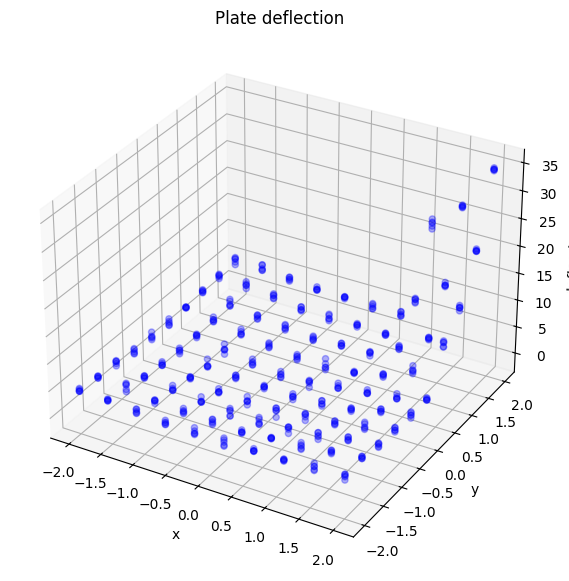

In [11]:
# Generate full dataset
X_all, y_all = generate_plate_data(n_samples=100, n_plates=5, noise_level=0.4)
total_samples = X_all.shape[0]

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_all[:,0], X_all[:,1], y_all, c="blue", alpha=0.3)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("deflection z")
ax.set_title("Plate deflection")
plt.show()

# Split into train/test
train_ratio = 0.7
train_size = int(total_samples * train_ratio)
X_train, y_train = X_all[:train_size], y_all[:train_size]
X_test, y_test   = X_all[train_size:], y_all[train_size:]


In [12]:
# Data preprocessing
x_scaler = StandardScaler()
y_scaler = StandardScaler()

# Normalizing our data, don't forget to unnormalize the predictions later!
X_train_scaled = torch.from_numpy(x_scaler.fit_transform(X_train.numpy())).float()
X_test_scaled = torch.from_numpy(x_scaler.transform(X_test.numpy())).float()
y_train_scaled = torch.from_numpy(y_scaler.fit_transform(y_train.numpy().reshape(-1, 1))).float().squeeze()
y_test_scaled = torch.from_numpy(y_scaler.transform(y_test.numpy().reshape(-1, 1))).float().squeeze()

## Model definition

In [13]:
# Model definition
class NetleF(nn.Module):
    """A very efficient neural network for the given task, probably the best for the job."""
    def __init__(self):
        super().__init__()
        layers = []
        layers.append(nn.Linear(2, 20)) # input layer
        for _ in range(8):
            layers.append(nn.Sigmoid()) # activation function
            layers.append(nn.Linear(20, 20)) # hidden layer
        layers.append(nn.Sigmoid()) # activation function
        layers.append(nn.Linear(20, 1)) # output layer
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

## Training

In [14]:
model = NetleF()

# Optimizer and loss
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(200):
    y_pred_scaled = model(X_train_scaled).squeeze()
    loss = loss_fn(y_pred_scaled, y_train_scaled)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        with torch.no_grad(): # no gradients coming from the test set
            test_pred_scaled = model(X_test_scaled).squeeze()
            test_loss = loss_fn(test_pred_scaled, y_test_scaled)
        print(f"Epoch {epoch:3d} | Train loss: {loss.item():.4f} | Test loss: {test_loss.item():.4f}")

Epoch   0 | Train loss: 1.2574 | Test loss: 51.7862
Epoch   5 | Train loss: 1.0624 | Test loss: 49.9870
Epoch  10 | Train loss: 1.0152 | Test loss: 49.1381
Epoch  15 | Train loss: 1.0037 | Test loss: 48.7287
Epoch  20 | Train loss: 1.0009 | Test loss: 48.5290
Epoch  25 | Train loss: 1.0002 | Test loss: 48.4311
Epoch  30 | Train loss: 1.0001 | Test loss: 48.3830
Epoch  35 | Train loss: 1.0000 | Test loss: 48.3593
Epoch  40 | Train loss: 1.0000 | Test loss: 48.3477
Epoch  45 | Train loss: 1.0000 | Test loss: 48.3419
Epoch  50 | Train loss: 1.0000 | Test loss: 48.3391
Epoch  55 | Train loss: 1.0000 | Test loss: 48.3377
Epoch  60 | Train loss: 1.0000 | Test loss: 48.3370
Epoch  65 | Train loss: 1.0000 | Test loss: 48.3367
Epoch  70 | Train loss: 1.0000 | Test loss: 48.3365
Epoch  75 | Train loss: 1.0000 | Test loss: 48.3364
Epoch  80 | Train loss: 1.0000 | Test loss: 48.3364
Epoch  85 | Train loss: 1.0000 | Test loss: 48.3363
Epoch  90 | Train loss: 1.0000 | Test loss: 48.3363
Epoch  95 | 

## Visualization of Results

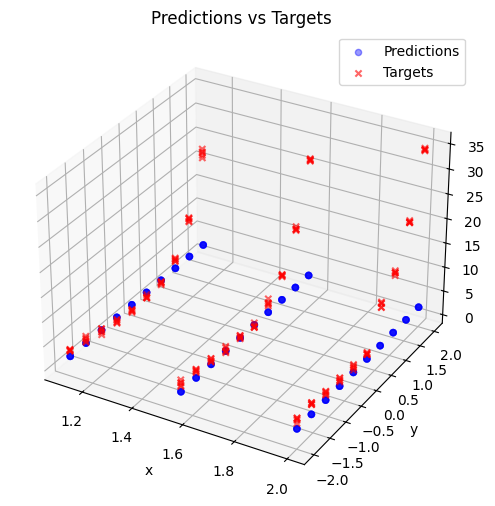

In [15]:
# Plot predictions vs targets in 3d
with torch.no_grad():
    test_pred_scaled = model(X_test_scaled).squeeze()
    test_pred = torch.from_numpy(y_scaler.inverse_transform(test_pred_scaled.numpy().reshape(-1, 1))).float().squeeze()
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(X_test[:, 0], X_test[:, 1], test_pred, c="blue", alpha=0.4, label="Predictions")
    ax.scatter(X_test[:, 0], X_test[:, 1], y_test, c="red", marker="x", alpha=0.6, label="Targets")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title("Predictions vs Targets")
    ax.legend()
    plt.show()